In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from new_helpers_may_17 import PopEstimator

Section 1: test prepare_data

  ID_hazard                                           geometry  buffer_dist_0  \
0      haz1                            POINT (-74.006 40.7128)           1000   
1      haz2  POLYGON ((-74.01 40.71, -74.01 40.72, -74 40.7...           1000   
2      haz3        LINESTRING (-74.015 40.705, -74.005 40.715)           1000   
3      haz4                         POINT (-73.93524 40.73061)           1000   
4      haz5            LINESTRING (-73.99 40.75, -73.98 40.76)           1000   

   buffer_dist_100  buffer_dist_200  buffer_dist_300  
0             2000             3000             1000  
1             2000             3000             1000  
2             2000             3000             1000  
3             2000             3000             1000  
4             2000             3000             1000  


<Axes: >

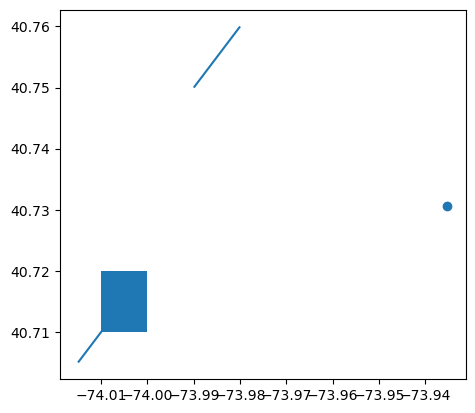

In [2]:
hazards = gpd.GeoDataFrame({
    "ID_hazard": ["haz1", "haz2", "haz3", "haz4", "haz5"],
    "geometry": [
        Point(-74.0060, 40.7128),  # Point: Manhattan
        Polygon([(-74.01, 40.71), (-74.01, 40.72), (-74.00, 40.72), (-74.00, 40.71)]),  # Polygon: Lower Manhattan
        LineString([(-74.015, 40.705), (-74.005, 40.715)]),  # Line: Lower Manhattan diagonal
        Point(-73.935242, 40.730610),  # Point: Queens
        LineString([(-73.99, 40.75), (-73.98, 40.76)])  # Line: Midtown Manhattan
    ],
    "buffer_dist_0": [1000, 1000, 1000, 1000, 1000],
    "buffer_dist_100": [2000, 2000, 2000, 2000, 2000],
    "buffer_dist_200": [3000, 3000, 3000, 3000, 3000],
    "buffer_dist_300": [1000, 1000, 1000, 1000, 1000]
}, crs="EPSG:4326")

print(hazards)
hazards.plot()

In [3]:
hazards.to_parquet("../local_data/test_hazards.parquet")

<Axes: >

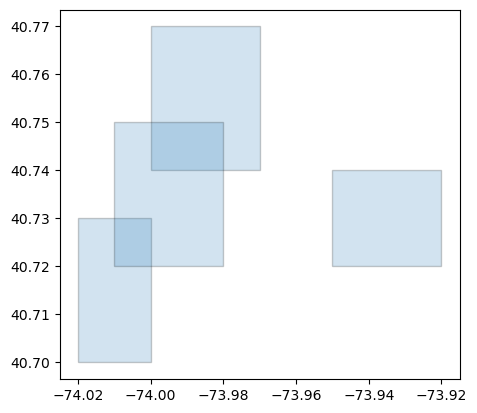

In [4]:
spatial_units = gpd.GeoDataFrame({
    "ID_spatial_unit": ["unit1", "unit2", "unit3", "unit4"],
    "geometry": [
        # Lower Manhattan
        Polygon([(-74.02, 40.70), (-74.02, 40.73), (-74.00, 40.73), (-74.00, 40.70)]),
        # Midtown Manhattan
        Polygon([(-74.00, 40.74), (-74.00, 40.77), (-73.97, 40.77), (-73.97, 40.74)]),
        # Queens (covers hazard 4)
        Polygon([(-73.95, 40.72), (-73.95, 40.74), (-73.92, 40.74), (-73.92, 40.72)]),
        # Central Manhattan (overlaps with several hazards)
        Polygon([(-74.01, 40.72), (-74.01, 40.75), (-73.98, 40.75), (-73.98, 40.72)]),
    ]
}, crs="EPSG:4326")

spatial_units.plot(edgecolor="k", alpha=0.2)

In [5]:
spatial_units.to_parquet("../local_data/test_units.parquet")

In [6]:
est = PopEstimator()

In [7]:
hazards = est.prepare_data("../local_data/test_hazards.parquet", geo_type='hazard')

In [8]:
print(hazards)

  ID_hazard                                  buffered_hazard_0  \
0      haz1  POLYGON ((-73.99416 40.7127, -73.99423 40.7118...   
1      haz2  POLYGON ((-74.01 40.70099, -74.01116 40.70104,...   
2      haz3  POLYGON ((-74.01442 40.72045, -74.01367 40.721...   
3      haz4  POLYGON ((-73.9234 40.7305, -73.92347 40.72962...   
4      haz5  POLYGON ((-73.98943 40.76545, -73.98868 40.766...   

                                 buffered_hazard_100  \
0  POLYGON ((-73.98233 40.71259, -73.98247 40.710...   
1  POLYGON ((-74.01 40.69198, -74.01232 40.69207,...   
2  POLYGON ((-74.02384 40.72591, -74.02235 40.727...   
3  POLYGON ((-73.91156 40.73039, -73.9117 40.7286...   
4  POLYGON ((-73.99886 40.7709, -73.99737 40.7722...   

                                 buffered_hazard_200  \
0  POLYGON ((-73.97049 40.71249, -73.9707 40.7098...   
1  POLYGON ((-74.01 40.68298, -74.01348 40.68311,...   
2  POLYGON ((-74.03327 40.73136, -74.03102 40.733...   
3  POLYGON ((-73.89972 40.73028, -73.89994

<Axes: >

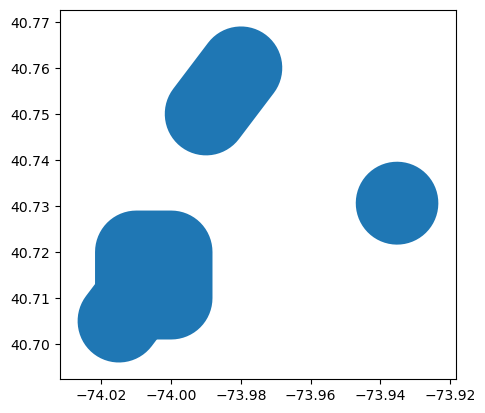

In [9]:
hazards.set_geometry('buffered_hazard_0')
hazards.plot()

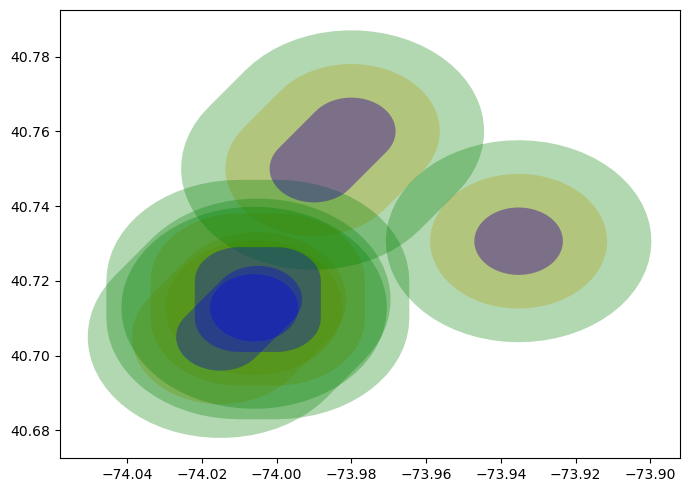

In [10]:
import matplotlib.pyplot as plt

buffer_cols = [col for col in hazards.columns if col.startswith("buffered_hazard")]

fig, ax = plt.subplots(figsize=(8, 8))

colors = ["red", "orange", "green", "blue"]
for col, color in zip(buffer_cols, colors):
    hazards.set_geometry(col).plot(ax=ax, alpha=0.3, color=color, label=col)

In [11]:
print(hazards["buffered_hazard_0"].equals(hazards["buffered_hazard_300"]))

True


In [12]:
print(hazards["buffered_hazard_0"].apply(lambda g: g.is_valid if g else False).sum())
print(hazards["buffered_hazard_300"].apply(lambda g: g.is_valid if g else False).sum())

5
5


It looks like prepare_data is working, for hazards.

In [13]:
spatial_units = est.prepare_data("../local_data/test_units.parquet", geo_type='spatial_unit')

In [14]:
print(spatial_units)

  ID_spatial_unit                                           geometry
0           unit1  POLYGON ((-74.02 40.7, -74.02 40.73, -74 40.73...
1           unit2  POLYGON ((-74 40.74, -74 40.77, -73.97 40.77, ...
2           unit3  POLYGON ((-73.95 40.72, -73.95 40.74, -73.92 4...
3           unit4  POLYGON ((-74.01 40.72, -74.01 40.75, -73.98 4...


<Axes: >

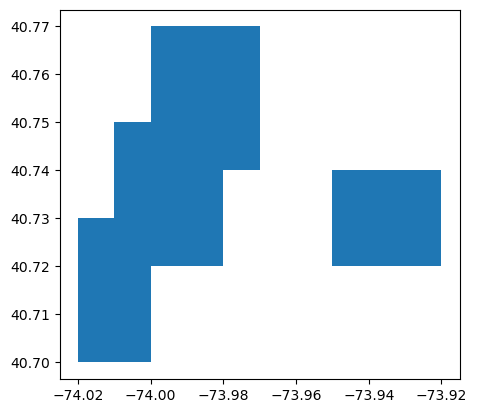

In [15]:
spatial_units.plot()

Looks good as well. Ok now for estimate_exposed_pop.

In [16]:
import pathlib
base_path = pathlib.Path.cwd().parent.parent

pop_dat_dir = base_path / "GHSL" / "1km" 

ghsl_2000 = pop_dat_dir / "GHS_POP_E2000_GLOBE_R2023A_54009_1000_V1_0" / "GHS_POP_E2000_GLOBE_R2023A_54009_1000_V1_0.tif"


In [17]:
est.spatial_units = None
exp = est.estimate_exposed_pop(pop_path=ghsl_2000, hazard_specific=True, hazards=hazards)

In [18]:
exp.head()

,ID_hazard,exposed_0,exposed_100,exposed_200,exposed_300
0,haz1,59870.981482,180927.819570,373320.363890,59870.981482
1,haz2,139719.054483,316056.154921,540867.967584,139719.054483
2,haz3,79468.685876,213160.673617,431621.022617,79468.685876
3,haz4,11800.042657,72260.656155,241989.759260,11800.042657
4,haz5,106231.146591,365181.695842,661144.603806,106231.146591


In [19]:
exp2 = est.estimate_exposed_pop(pop_path=ghsl_2000,
                                spatial_units=spatial_units, hazard_specific=True, hazards=hazards)

In [20]:
exp2.head()

,ID_hazard,ID_spatial_unit,exposed_0,exposed_100,exposed_200,exposed_300
0,haz1,unit1,45641.879864,72033.815635,72194.900707,45641.879864
1,haz1,unit4,3114.281139,49292.776400,146162.006315,3114.281139
2,haz2,unit1,69538.910378,72194.900707,72194.900707,69538.910378
3,haz2,unit2,0.000000,0.000000,27604.165900,0.000000
4,haz2,unit4,39200.043448,135512.341436,215331.487509,39200.043448


In [ ]:
pop = est.estimate_pop(pop_path=ghsl_2000, spatial_units=spatial_units)

In [ ]:
print(pop)

  ID_spatial_unit     population
0           unit1   72194.900707
1           unit2  164069.985392
2           unit3   25102.101721
3           unit4  244348.414063
